# Korteweg–De Vries equation

* Physical space
\begin{align}
u_t + u_{xxx}u +6uu_x = 0
\end{align}
* Spectral space $\hat{u} = \mathscr{F}\{u\}$
\begin{align}
\hat{u_t} = i k_x^3 \hat{u} - 6\mathscr{F} \{ \mathscr{F}^{-1} \{ u \} \mathscr{F}^{-1} \{ ik_x \hat{u}\} \}
\end{align}

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rkstiff.grids import construct_x_kx_rfft
from rkstiff.etd34 import ETD34
from rkstiff.etd4 import ETD4
%matplotlib inline

# Construct grids

In [3]:
# uniform grid spacing, field assumed to be real-valued -> construct_x_kx_rfft
N = 512
a, b = -150, 150
x,kx = construct_x_kx_rfft(N,a,b)

# Linear and nonlinear functions for spectral kdV equation

In [26]:
L = 1j*kx**3
def NLfunc(uf):
    u = np.fft.irfft(uf)
    ux = np.fft.irfft(1j*kx*uf)
    return -6*np.fft.rfft(u*ux)

# Initial values set to a combination of kdV solitons

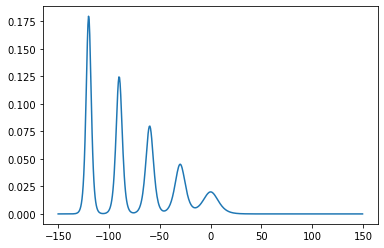

In [5]:
A0 = np.array([0.6, 0.5, 0.4, 0.3, 0.2]).reshape(1,5)
x0 = np.array([-120, -90, -60, -30, 0]).reshape(1,5)
u0 = 0.5*A0**2/(np.cosh(A0*(x.reshape(N,1)-x0)/2)**2)
u0 = np.sum(u0,axis=1)
u0FFT = np.fft.rfft(u0)

plt.plot(x,u0)

# Initialize constant-step ETD4 and adaptive-step ETD34 solvers

In [8]:
solverCS = ETD4(linop=L,NLfunc=NLfunc) # Try ETD5 for a 5th order method
solverAS = ETD34(linop=L,NLfunc=NLfunc,epsilon=1e-4)

# Propagate from time t0 to tf

In [20]:
# store_data -> propagated field stored in solver.u at times solver.t 
# store_freq -> propagated field values stored on every store_freq step (default is every step)
uFFT_CS = solverCS.evolve(u0FFT,t0=0,tf=600,h=0.1,store_data=True,store_freq=100)
uFFT_AS = solverAS.evolve(u0FFT,t0=0,tf=600,h_init=0.1,store_data=True,store_freq=25)

# Graph propagation

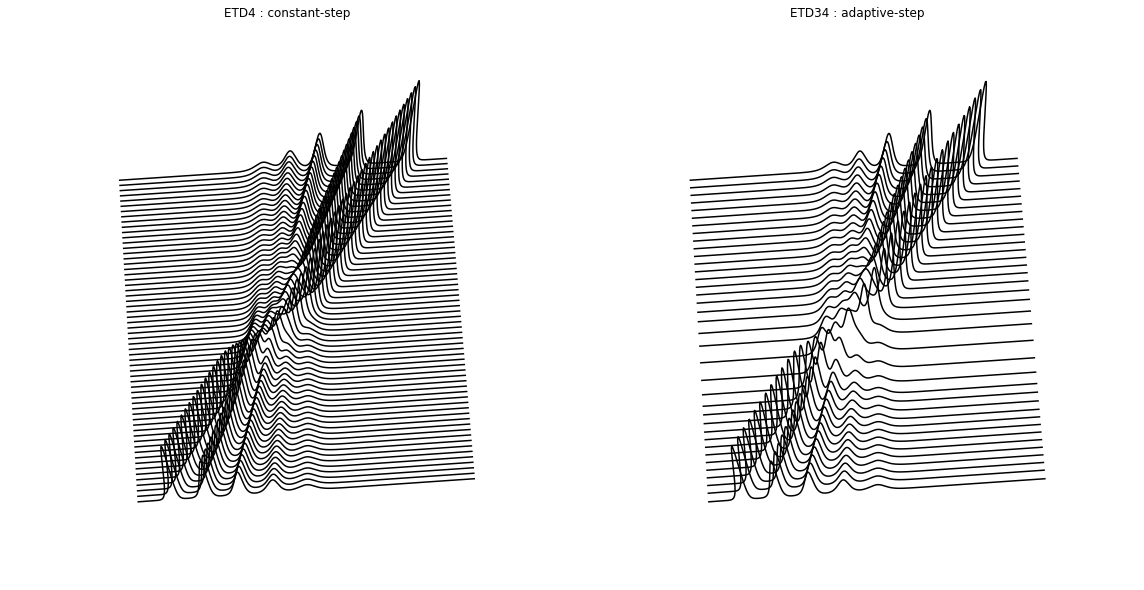

In [27]:
T = [solverCS.t,solverAS.t]
U_FFT = [solverCS.u,solverAS.u]
fig = plt.figure(figsize=(16,12))
titles = ['ETD4 : constant-step','ETD34 : adaptive-step']
for i in range(len(T)):
    ax = fig.add_subplot(1,2,i+1,projection='3d')
    ax.w_xaxis.set_pane_color((0,0,0,0))
    ax.w_yaxis.set_pane_color((0,0,0,0))
    ax.w_zaxis.set_pane_color((0,0,0,0))
    t = np.array(T[i])
    for j,snapshot_fft in enumerate(U_FFT[i]):
        snapshot = np.fft.irfft(snapshot_fft)
        ax.plot(x,t[j]*np.ones_like(x),snapshot,color='black')
    ax.set_xlim([x[0],x[-1]])
    ax.set_ylim([t[0],t[-1]])
    ax.grid(False)
    ax.axis(False)
    ax.view_init(75,-94)
    ax.set_title(titles[i])
plt.tight_layout()